In [7]:

import followthemoney as ftm
import followthemoney.model as model
import pandas
import json
import numpy as np
import math
from urllib import parse as url_parse
from pprint import pprint
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics as metrics 
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import seaborn as sb

# Importing and preprocessing

In [5]:
# local import for easier reproducibility 
json_path = "./data/meineabgeordneten_agg.json"

def read_ftm_json(path):
    entity_dicts = []
    with open(path) as f:
        for line in f:
            entity_dicts.append(json.loads(line))
    return entity_dicts

entity_dicts = read_ftm_json(json_path)

In [6]:
person_dicts = [entity for entity in entity_dicts if entity["schema"] == "Person"]
ftm_proxies =[model.get_proxy(entity) for entity in entity_dicts]
ftm_persons = [proxy for proxy in ftm_proxies if proxy.schema.name == "Person"]
ftm_organizations = [proxy for proxy in ftm_proxies if proxy.schema.name == "Organization"]
ftm_companies = [proxy for proxy in ftm_proxies if proxy.schema.name == "Company"]
person_assignments = pandas.read_csv("./data/csv/new/Person_wikidata.csv")[["id", "wikidata"]]

In [7]:
ftm_persons_wd = {proxy.id: proxy.clone() for proxy in ftm_proxies}

In [9]:
dicts = []
output_json = open("./data/output/meineabgeordneten_wikidata.json","w")
for index, row in person_assignments.iterrows():
    ftm_ent = ftm_persons_wd[row.id]
    ftm_ent.add("wikidataId", row["wikidata"])
    

for _, ftm_ent in ftm_persons_wd.items():
    json_ent = json.dumps(ftm_ent.to_dict(), sort_keys=True)
    output_json.write(json_ent + "\n")


In [2]:
a ={}
a[None] = None
if None in a:
    print(2)

In [8]:
person_assignments.head()

,id,wikidata
0,00023638949ec143e690ae151d28e389574f07dc,Q51533040
1,001d48bf2913572202d88f00e35262f490771b40,Q81526090
2,00ad3c5b5a651f6e00080803ffefb1d306c6d027,Q20752545
3,00def69ad3d13efe8151da80f1485a692954d183,Q102353097
4,00e70efc17aff680e675349ca87d7b80be04c452,Q50843964


In [9]:
print(len(ftm_persons), len(person_assignments))

766 766


All properties of entities are multivalued, although they mostly hold only one single value. I transform the data in order to call the API with single-valued properties.

In [11]:
def entity2df(entities):   
    flat_entities = []
    for entity in entities:
        prop_dict ={}
        for prop, val in entity.properties.items():
            prop_dict["id"] = entity.id
            prop_dict[prop] = val[0] if len(val)== 1 else  val
        flat_entities.append(prop_dict)
    return pandas.DataFrame.from_dict(flat_entities)




In [11]:
# Dataframe with Wikidata Cells
clean_person_df = entity2df(ftm_persons).merge(person_assignments,on="id")
clean_person_df

,id,birthDate,birthPlace,country,email,firstName,lastName,name,sourceUrl,summary,website,title,wikidata
0,00023638949ec143e690ae151d28e389574f07dc,1987-02-23,Innsbruck,at,buero.wohlgemuth@oegb.at,Philip,Wohlgemuth,Philip Wohlgemuth,https://www.meineabgeordneten.at/Abgeordnete/p...,Abgeordneter zum Landtag,"[https://www.facebook.com/philip.wohlgemuth, h...",NaN,Q51533040
1,001d48bf2913572202d88f00e35262f490771b40,1976-06-25,Wiener Neustadt,at,waltraud.ungersboeck@noel.gv.at,Waltraud,Ungersböck,Waltraud Ungersböck,https://www.meineabgeordneten.at/Abgeordnete/W...,"[Vizebürgermeisterin, Abgeordnete zum Landtag,...",[https://www.facebook.com/profile.php?id=10001...,NaN,Q81526090
2,00ad3c5b5a651f6e00080803ffefb1d306c6d027,1971-02-27,Rottenmann,at,armin.forstner@stvp.at,Armin,Forstner,Armin Forstner,https://www.meineabgeordneten.at/Abgeordnete/a...,"[Natur- und Geopark Steirische Eisenwurzen, Bü...",https://www.facebook.com/a.forstner/,NaN,Q20752545
3,00def69ad3d13efe8151da80f1485a692954d183,1980-10-20,Wien,at,spassfabrik@gmx.at,Silvia,Janoch,Silvia Janoch,https://www.meineabgeordneten.at/Abgeordnete/s...,"[KINDERGRUPPE SPASSFABRIK, Abgeordnete zum Wie...",https://www.facebook.com/silvia.janoch,Dipl.-Päd.,Q102353097
4,00e70efc17aff680e675349ca87d7b80be04c452,1970-07-10,Eisenstadt,at,elvira.schmidt@spoe.at,Elvira,Schmidt,Elvira Schmidt,https://www.meineabgeordneten.at/Abgeordnete/e...,"[Verein der Freundinnen der ""Frau und Politik""...",https://www.facebook.com/virli.schmidt,NaN,Q50843964
...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,fcc94a122228733902b6f601abc54631aa205a4b,1963-01-16,Radstadt,at,liesl.weitgasser@neos.eu,Elisabeth,Weitgasser,Elisabeth Weitgasser,https://www.meineabgeordneten.at/Abgeordnete/e...,"[S-berg Hotel Ges.m.b.H., Abgeordnete zum Land...","[https://www.instagram.com/weitgasserliesl/, h...",NaN,Q54956531
762,fd6b5ddebf7ed34449bac5a96eb2acbdbf5e4a3e,1966-11-04,Wien,at,elisabeth.trummer.spoe@gmail.com,Elisabeth,Trummer,Elisabeth Trummer,https://www.meineabgeordneten.at/Abgeordnete/e...,"[""mittelburgenland plus"", Verein zur Dynamisie...",https://www.facebook.com/Trummerelisabeth,NaN,Q84091498
763,fdc8f2275cf8bea8331ea4a779755915d0c29363,NaN,NaN,at,daniela.schmid@ages.at,Daniela,Schmid,Daniela Schmid,https://www.meineabgeordneten.at/Abgeordnete/d...,NaN,NaN,Priv.-Doz.in Dr.in,NaN
764,fe532c498a07fc06380579af855e68389239c43b,1964-06-30,Graz,at,andrea-michaela.schartel@parlament.gv.at,Andrea Michaela,Schartel,Andrea Michaela Schartel,https://www.meineabgeordneten.at/Abgeordnete/A...,"[RSP-Personalverrechnung GmbH, Mitglied des Bu...",[https://www.facebook.com/Andrea-Michaela-Scha...,NaN,Q19501935


# Reconciliation

In [12]:
import requests
import urllib
reconciliation_endpoint = urllib.parse.urlparse("https://wikidata.reconci.link/de/api")
suggest_endpoint = urllib.parse.urlparse("https://wikidata.reconci.link/de/suggest")


Ontology alignment was statically performed with 3 variations. At the first mapping (mapping_full) all available properties are mapped according to Wikidata, if a corresponding property existed. In the second one, properties that are seldomoly existent in Wikidata were omitted. In the last one, a minimal set of properties were mapped to evaluate the scoring mechanism.

In [13]:
mapping_full = {
    "birthDate" : "P569",
    "birthPlace" : "P19",
    "email" : "P968",
    "firstName" : "P735",
    "lastName" : "P734",
    "title" : "P512",
    "website" : "P856"
}

In [14]:
mapping_refined = {
    "birthDate" : "P569",
    "birthPlace" : "P19",
    #"email" : "P968",
    "firstName" : "P735",
    "lastName" : "P734",
    "title" : "P512",
    #"website" : "P856"
}

In [15]:
mapping_sparse = {
    "birthDate" : "P569",
}

In [16]:
def createQuery(entity, type, mapping, limit = 10):
    query_params = {}
    query_params["query"] = entity.first("name")
    query_params["type"] = type
    query_params["properties"] = []
    query_params["limit"] = limit # candidate limit
    for prop, value in entity.properties.items():
        #print(prop, mapping.get(prop))
        wikidataId = mapping.get(prop)
        if wikidataId:
            prop = {"pid": wikidataId, "v": value[0] if len(value)== 1 else  value}
            query_params["properties"].append(prop)   
 
    return query_params
    


In [17]:
createQuery(ftm_persons[3], "Q5", mapping_sparse)

{'query': 'Silvia Janoch',
 'type': 'Q5',
 'properties': [{'pid': 'P569', 'v': '1980-10-20'}],
 'limit': 10}

In [18]:
def create_batch_queries(entities, type, mapping, batch_size = 10):
    start = 0
    end = 0 + batch_size
    batches =[]
    for batch_nr in range(math.ceil(len(entities)/batch_size)):
        queries = {"q"+str(i):createQuery(entity, type, mapping) for i, entity in enumerate(ftm_persons[start:end])}
        batches.append(queries)
        start += batch_size
        end += batch_size
    return batches
    

In [19]:
def query_endpoint(query_batches):
    results = []
    for batch_query in query_batches:
        response = requests.post(reconciliation_endpoint.geturl(), data = {"queries": json.dumps(batch_query)})
        results.extend([resp for index, resp in response.json().items()])
    return results

For each mapping a distinct dataset is created. Due to reproducibility reasons, the API results are persisted. Also, each batch query processing takes approximately 3 minutes, making 9 minutes in total.

In [20]:
get_path =  lambda name: "./data/intermediate/api_responses_{}.json".format(name)

def query_and_persist(entities, type, mapping, name):
    batch_queries = create_batch_queries(ftm_persons, "Q5", mapping) 
    results = query_endpoint(batch_queries)
    json.dump(results, open(get_path(name),"w"))
    return results

In [21]:
%%time

if False:
    # Q5 is the Wikidata ID for type "Human".
    results_full = query_and_persist(ftm_persons, "Q5", mapping_full, "mapping_full") 
    results_refined = query_and_persist(ftm_persons, "Q5", mapping_refined, "mapping_refined") 
    results_sparse = query_and_persist(ftm_persons, "Q5", mapping_sparse, "mapping_sparse") 
    
else:
    
    results_full = json.load(open(get_path("mapping_full")))
    results_refined = json.load(open(get_path("mapping_refined")))
    results_sparse = json.load(open(get_path("mapping_sparse")))
    #results = json.load(open("./data/intermediate/api_responses_without_email.json"))

CPU times: user 130 ms, sys: 9.12 ms, total: 139 ms
Wall time: 142 ms


# Analysis of the Record Linkage


Knitting together API response and data to create a pandas table for further processing. 

In [22]:
def create_cd_table(results, entities):
    intermed_table = []
    header = ["id", "name", "cd_wd_id", "cd_name","cd_match_pred", "cd_score", "comparison_vec"]
    for result, entity in zip(results, entities):
        candidates = result["result"]
        if len(candidates) > 0: 
            for candidate in candidates:
                intermed_table.append([entity.id,entity.first("name"), candidate["id"], candidate["name"], \
                    candidate["match"], candidate["score"], candidate["features"]])
        # If no results in response
        else: 
            intermed_table.append([entity.id,entity.first("name"), None, None, \
                False, None, None]) # implicit false made explicit

    cd_table = pandas.DataFrame(intermed_table, columns= header).merge(person_assignments,on="id")
    
    cd_table = cd_table.assign(match =  lambda x: x["wikidata"] == x["cd_wd_id"], 
                     tp = lambda x: x["match"] & x["cd_match_pred"],
                     rank = lambda x: x.groupby("id").cumcount().values + 1,
                     prop_count = lambda x: x["comparison_vec"].apply(lambda y: len(y) if y else 0),
                     threshold = lambda x: 95 - 5*(x["prop_count"]-1))
    
    return cd_table

cd_table_full = create_cd_table(results_full, ftm_persons)
cd_table_refined = create_cd_table(results_refined, ftm_persons)
cd_table_sparse = create_cd_table(results_sparse, ftm_persons)

Before calculating scores based on similarity measures, the Wikidata Reconciliation API performs a candidate selection based on the WikiMedia API Elasticsearch search-engine by querying the value in the "query" property inside the request, which corresponds to the name of an item (at least in the OpenRefine implementation, as well as here). Obviously, there is a high tendency to return just one matching result.

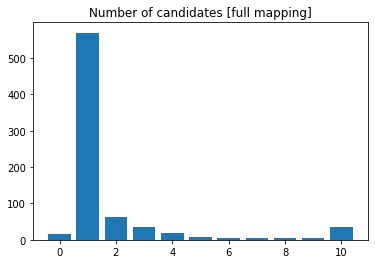

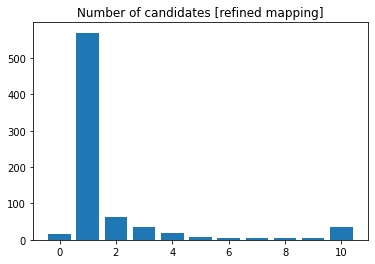

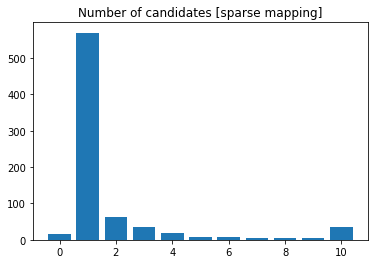

In [23]:

def num_cd_plt(api_results, description):
    cd_num_counts = pandas.DataFrame([len(result["result"]) for result in api_results], columns=["cd_num"])
    cd_occ_counts =  cd_num_counts.groupby("cd_num").size().to_frame("count")

    plt.bar(cd_occ_counts.index, cd_occ_counts["count"])
    plt.title("Number of candidates " + description)
    

num_cd_plt(results_full, "[full mapping]")
plt.show()
num_cd_plt(results_refined, "[refined mapping]")
plt.show()
num_cd_plt(results_sparse, "[sparse mapping]")

,name,cd_wd_id,cd_name,cd_match_pred,cd_score,wikidata,match
id,,,,,,,
00023638949ec143e690ae151d28e389574f07dc,Philip Wohlgemuth,Q51533040,Philip Wohlgemuth,True,86.666667,Q51533040,True
001d48bf2913572202d88f00e35262f490771b40,Waltraud Ungersböck,Q81526090,Waltraud Ungersböck,True,86.666667,Q81526090,True
00ad3c5b5a651f6e00080803ffefb1d306c6d027,Armin Forstner,Q20752545,Armin Forstner,True,73.333333,Q20752545,True
00def69ad3d13efe8151da80f1485a692954d183,Silvia Janoch,Q102353097,Silvia Janoch,False,52.941176,Q102353097,True
00e70efc17aff680e675349ca87d7b80be04c452,Elvira Schmidt,Q50843964,Elvira Schmidt,True,86.666667,Q50843964,True
...,...,...,...,...,...,...,...
fcc94a122228733902b6f601abc54631aa205a4b,Elisabeth Weitgasser,Q54956531,Elisabeth Weitgasser,True,73.333333,Q54956531,True
fd6b5ddebf7ed34449bac5a96eb2acbdbf5e4a3e,Elisabeth Trummer,Q84091498,Elisabeth Trummer,True,86.666667,Q84091498,True
fdc8f2275cf8bea8331ea4a779755915d0c29363,Daniela Schmid,Q87653139,Daniela Schmid,False,81.818182,NaN,False


As the data is about person of interests, it is heavly biased towards well known entities that actually have a Wikidata (and Wikipedia) page, which corresponds to the scenario layed out in the thesis.

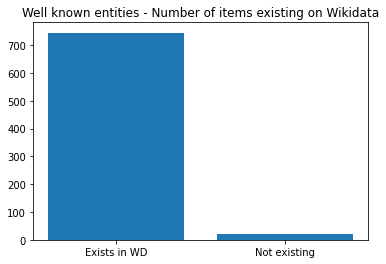

In [24]:

def well_known_count(cd_table):
    cd_first_candidate = cd_table.groupby("id").first()
    has_match = ~cd_first_candidate["wikidata"].isna()
    has_match.value_counts()
    plt.bar(["Exists in WD", "Not existing"],has_match.value_counts())
    plt.title("Well known entities - Number of items existing on Wikidata")
well_known_count(cd_table_full)


## Overview 
The threshold of Wikidata's Reconciliation Service was automatically set by the service, following this equation:

$t = t_{val} - d \cdot |p| = 95 - 5 \cdot |p|$

where:<br>
$t_{val}$ ... the fixed validation threshold set by the service. This value is statically set to 95<br>
$d$ ... The fixed validation discount set by the service. This value is statically set to 5 <br>
$p$ ... The set of properties queried


Candidates that exceeded this threshold are considered as a match. Other candidates returned demand further human judgment. The service does not offer partial matches, which would require a second (lower) threshold. However, the service reveals candidate to the user for further judgement. The size of candidates is limited to 10 Candidates for this case. 

Record Linkage regarding Wikidata may return a maximum of 1 match, as Wikidata itself generally does not hold duplicates (although there are exceptions).


### Overview regarding matching decision
Overview on the decisions of the service: Most decisions are true positives. If not in virtually any case, the true entity was in the set of candidate revealed by the service. There are major differences regarding the data.

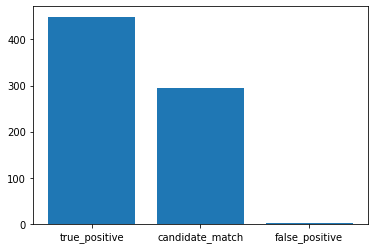

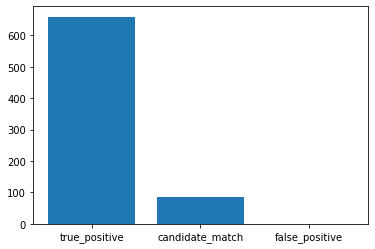

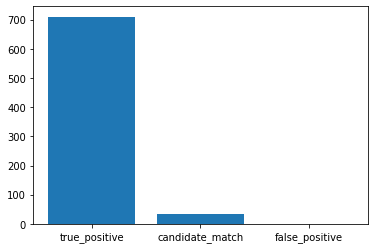

In [25]:
def matching_overview(cd):
    cd = cd[~cd["wikidata"].isna()]
    any_cd_match = cd[["match", "tp"]].groupby(cd["id"]).any()#.to_frame("any_cd_match")
    any_cd_match["match_category"] = np.select([
        any_cd_match["match"] & any_cd_match["tp"],
        any_cd_match["match"]
    ],[ "true_positive", "candidate_match"], default="false_positive")
    any_cd_match["match_category"].value_counts()

    match_category = any_cd_match["match_category"].value_counts()
    plt.bar(match_category.index,match_category)
#TODO erste grafik FP anschauen
matching_overview(cd_table_full)
plt.show()
matching_overview(cd_table_refined)
plt.show()
matching_overview(cd_table_sparse)
plt.show()


# Evaluating Matching decisions 
The matching decision is evaluated seperatly from the ranking of candidates.
The API marks at most one as a match, never two ore more items. This leads to following consequences:

$PRECISION = \frac{TP}{TP + FP}$

$RECALL = \frac{TP}{TP + FN}$
<hr>

### Case 1 (correct match): 
$TP = 1 => FP = 0, FN = 0$ 

RECALL = PRECISION = 1

### Case 2 (uncorrect match, but item exists)

$TP = 0,  FP = 1, FN = 1$

RECALL = PRECISION = 0


### Case 3 (no match, but item exists);
$TP = 0, FP = 0,  FN = 1 $

PRECISION is undefined

RECALL = 0

### Case 4 (uncorrect match, and item does not exist)
$TP = 0,  FP = 1,   FN = 0$

PRECISION = 0 

RECALL is undefined

### Case 5 (no match and item does not exist)
$TP = FP = FN = 0

PRECISION and RECALL undefined

<hr>

As I am conviced that those edge cases contain valid information I will set both, precision and recall, to 1 (in case of 5) and 0 (in case of 3 or 4). Note that the separation of non-match cases between the retrieval in the candidate set versus missing entity in the candidate set is not performed here, as we are looking into the MATCHING decision and not the retrieval at this point.

As the last 2 cases do not contain information about the matching decision, cases without a matching Wikidata item are filtered out. These applies to 21.


In [26]:
#cd_full = cd_table_full[~(cd_table_full["wikidata"].isna() & cd_table_full["cd_wd_id"].isna())]
#cd_refined = cd_table_refined[~(cd_table_refined["wikidata"].isna() & cd_table_refined["cd_wd_id"].isna())]
#cd_sparse = cd_table_sparse[~(cd_table_sparse["wikidata"].isna() & cd_table_sparse["cd_wd_id"].isna())]

## Macro Averaged Precision and Recall

In [28]:
f_beta = lambda b,prec, rec: (1+b**2) * (prec * rec)/((b**2) * prec + rec)
def performance_metrics(cd):
        pred =cd["cd_match_pred"]
        truth = cd["match"]

        # Count TP, FP, FN per query and add one to FN if 
        # wikidata item exists and  is not in candidates.
        cd_metrs = (cd.assign(tp = pred & truth,
                        fp = pred & ~truth,
                        fn = (~pred & truth))
                .filter(["id", "tp", "fp", "fn"])
                .groupby("id")
                .sum()
                .merge(person_assignments, on = "id")
                .assign(match_exists = lambda x: ~x["wikidata"].isna())
                .drop("wikidata", axis = 1)
                .assign(all_zero = lambda x: (x["tp"]==0) & (x["fp"] == 0) & (x["fn"] == 0),     
                        missing_relevant = lambda x: x["all_zero"] & x["match_exists"],
                        fn = lambda x: np.where(x["missing_relevant"], 1, x["fn"])))

        # Calculate precision and recall per query and manually set edge cases.
        cd_metrs = (cd_metrs.assign(precision = lambda x:  x["tp"] / (x["tp"] + x["fp"]))
                        .assign(precision = lambda x: np.select([
                                x["precision"].isna() & (x["fp"] == 0) & (x["fn"] == 0), # Case 5
                                x["precision"].isna()], # Case 3 or 4
                                [1, 0],
                                default=x["precision"]))
                        .assign(recall = lambda x:  x["tp"] / (x["tp"] + x["fn"]))
                        .assign(recall = lambda x: np.select([
                                x["recall"].isna() & (x["fp"] == 0) & (x["fn"] == 0),   # Case 5     
                                x["recall"].isna()], # Case 3 or 4
                                [1, 0],
                                default=x["precision"]))
                        )

        micro = cd_metrs.filter(["tp", "fp", "fn"]).sum().to_frame().T
        macro = cd_metrs.filter(["precision", "recall"]).mean()
        micro_prec = micro["tp"] / (micro["tp"] + micro["fp"])
        micro_rec = micro["tp"] / (micro["tp"] + micro["fn"]) 
        return {
                "micro_avg_prec" : micro_prec[0],
                "micro_avg_rec" :  micro_rec[0],
                "macro_avg_prec" : macro["precision"],
                "macro_avg_rec" : macro["recall"],
                "macro_f1" : f_beta(1, macro["precision"], macro["recall"]),
                "micro_f1" : f_beta(1,micro_prec[0], micro_rec[0]),
                "micro_f0.5": f_beta(0.5,micro_prec[0], micro_rec[0]),
                "tp": micro["tp"][0],
                "fn": micro["fn"][0],
                "fp": micro["fp"][0]
        }
perf_metrics = {
        "full" :performance_metrics(cd_table_full),
        "refined" :performance_metrics(cd_table_refined),
        "sparse" : performance_metrics(cd_table_sparse)}
       
pandas.DataFrame(perf_metrics)            

,full,refined,sparse
micro_avg_prec,1.000000,1.000000,1.000000
micro_avg_rec,0.602685,0.884564,0.953020
macro_avg_prec,0.613577,0.887728,0.954308
macro_avg_rec,0.613577,0.887728,0.954308
macro_f1,0.613577,0.887728,0.954308
micro_f1,0.752094,0.938746,0.975945
micro_f0.5,0.883510,0.974564,0.990237
tp,449.000000,659.000000,710.000000
fn,296.000000,86.000000,35.000000
fp,0.000000,0.000000,0.000000


As we can see, the matching algorithm is poor. The more data is transmitted to the reconciliation API, the weaker are the results, due to more comparison scores evaluate to 0 even though it should be the opposite. However, as we can see at the micro averaged precision, when the algorithm decides that a pair is a match, it is accurate. Hence, there are no false positives, which is extremely important.

# Evaluating the Ranking
The Wikidata Reconciliation API makes rather conservative decisions, surfacing no false positives, but many false negatives. In this case, false positives would be worse, as we would create an inconsistent entity instead of just an incomplete one. Still, in many cases the right item was inside the list of candidates - mostly at the very top. As the service was built for additional human judgement, the ranking of the candidates is of utmost importance.

## Mean Reciprocal Rank
The [mean reciprocal rank](https://en.wikipedia.org/wiki/Mean_reciprocal_rank) takes the positition of the FIRST relevant item into account. This makes sense here, as we have a maximum of 1 match. We want to score higher if the match is at position 1 (mrr= 1/1) than if it is at rank 3 (mrr = 1/3).

$MRR = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \frac{1}{rank_i}$

Considering this, the reconciliation API returns good results, which indicates that the scoring threshold could be lower.

TODO When there is only one relevant answer in your dataset, the MRR and the MAP are exactly equivalent under the standard definition of MAP. https://stats.stackexchange.com/questions/127041/mean-average-precision-vs-mean-reciprocal-rank

https://link.springer.com/referenceworkentry/10.1007%2F978-0-387-39940-9_488

In [30]:
def mrr(cd):
    cd_first =  cd[~cd["wikidata"].isna()].groupby("id").first()
    hits = cd[cd["match"]]
    # Hits eliminates cases, no candidates where retrieved, but item exists in wikidata. We need it when dividing though, diff = len(cd_first) - len(hits) 
    print(len(cd_first) - len(hits))
    mrr = (1 / hits["rank"]).sum() / len(cd_first)
    return mrr

mrr_metrics = {
    "full": mrr(cd_table_full), 
"refined": mrr(cd_table_refined),
"sparse": mrr(cd_table_sparse)}
mrr_metrics

1
1
1


{'full': 0.9973154362416108,
 'refined': 0.9973154362416108,
 'sparse': 0.9969127516778524}

### Compare to Search API
To assess the ranking compared to a straight search against the API we will query the names of the entities against the MediaWiki search API, which also is used by the reconciliation API internally.
Again, for reasons of time and reproducibility, the responses are persisted.

In [31]:
%%time

search_endpoint = url_parse.urlparse("https://www.wikidata.org/w/api.php?action=wbsearchentities")
params = {
    "search": "",
    "language": "de",
    "strictlanguage": "false",
    "type": "item",
    "limit": 10,
    "format": "json"
}
def mediawikiSearch(entities):
    search_dicts = []
    for person in entities:
        params["search"] = person.first("name")
        results = requests.get(search_endpoint.geturl(), params=params)
        candidates = results.json()["search"]
        if len(candidates):
            for candidate in candidates:
                mapped = {
                    "id": person.id,
                    "name": person.first("name"),
                    "cd_wd_id": candidate["id"],
                    "cd_name": candidate["label"]}
                search_dicts.append(mapped)
        else: 
            mapped = {
                "id": person.id,
                "name": person.first("name")}
            search_dicts.append(mapped)
    return pandas.DataFrame(search_dicts)

# mw = mediawiki
mw_csv_path = "./data/intermediate/media_wiki_results.csv"
if False: # reproducibility/replicability
    __cd_mw = mediawikiSearch(ftm_persons)
    __cd_mw.to_csv(mw_csv_path)
else:
    __cd_mw = pandas.read_csv(mw_csv_path)

#for 

CPU times: user 6.74 ms, sys: 921 µs, total: 7.66 ms
Wall time: 6.8 ms


The search API already returns okayish results.

In [32]:
cd_mw = (__cd_mw
            .merge(person_assignments, on="id", how = "left")
            .assign(match = lambda x: x["cd_wd_id"] == x["wikidata"],
                    rank = lambda x: x.groupby("id").cumcount().values + 1)
            )
#cd_mw = cd_mw[~cd_mw["wikidata"].isna()]
mrr_metrics["search"] = mrr(cd_mw)
pandas.DataFrame(mrr_metrics, index= ["mrr"])

2


,full,refined,sparse,search
mrr,0.997315,0.997315,0.996913,0.967315


# Back to Classification
### Metrics @1
I define a trivial classifier, which queries the name in the API and marks the first result as a match. 

In [33]:
def comp_metrics_at_1(cd):
    cd_first= cd.groupby("id").first()
    return performance_metrics(cd_first)
    

In [34]:
cd_mw_first_match = cd_mw.assign(cd_match_pred = True)
perf_metrics["search@1"] = comp_metrics_at_1(cd_mw_first_match)
perf_metr_df = pandas.DataFrame(perf_metrics)
perf_metr_df

,full,refined,sparse,search@1
micro_avg_prec,1.000000,1.000000,1.000000,0.920366
micro_avg_rec,0.602685,0.884564,0.953020,1.000000
macro_avg_prec,0.613577,0.887728,0.954308,0.920366
macro_avg_rec,0.613577,0.887728,0.954308,0.920366
macro_f1,0.613577,0.887728,0.954308,0.920366
micro_f1,0.752094,0.938746,0.975945,0.958532
micro_f0.5,0.883510,0.974564,0.990237,0.935261
tp,449.000000,659.000000,710.000000,705.000000
fn,296.000000,86.000000,35.000000,0.000000
fp,0.000000,0.000000,0.000000,61.000000


## Enhancing the Threshold?

We clearly see that the scoring capability is somewhat off. Here we can try if a lower threshold could fix the discrepancies by plotting the resulting F1 value. However, this is a simplification, as the Wikidata scoring algorithm does not decide a match if the gap between both scores is smaller than 10.

In [35]:
def simulate_th_to_f1(cd):
    adapted_ths = []
    debug = []
    cd_first = cd.groupby("id").first()
    for i in range(-25,60,1):
        
        adapted_th= cd_first.assign(threshold = lambda x: x["threshold"] - i 
            ,cd_match_pred = lambda x: x["cd_score"] >= x["threshold"])

        adapted_match = cd.merge(adapted_th.filter(["id","cd_wd_id","cd_match_pred"]), on=["id", "cd_wd_id"], how="left").assign(cd_match_pred = lambda x: np.where(x["cd_match_pred_y"].isna(), x["cd_match_pred_x"], x["cd_match_pred_y"]))
        debug.append(adapted_match)
        adapted_ths.append([-i, performance_metrics(adapted_match)])
    return adapted_ths

adapted_ths = simulate_th_to_f1(cd_table_full)

In [36]:
th2df = lambda y: pandas.DataFrame([{"th_offset": metr[0], y: metr[1][y]} for metr in adapted_ths ])

ths_prec = th2df("micro_avg_prec")
ths_rec = th2df("micro_avg_rec")
ths_f1 = th2df("micro_f1")
ths_f0_5 = th2df("micro_f0.5")


## F1 and threshold adaption

th_offset   -37.000000
micro_f1      0.991979
Name: 62, dtype: float64


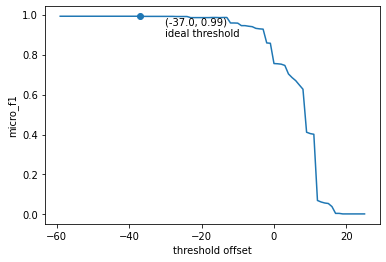

th_offset    -13.000000
micro_f0.5     0.991016
Name: 38, dtype: float64


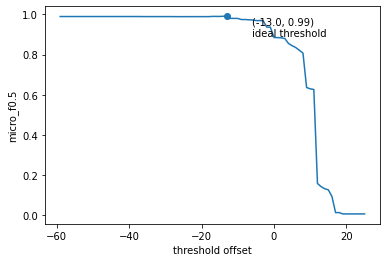

In [37]:
#f1_ths
def plt_f1_th(ths_f1, col):
    max_f1 = ths_f1.loc[ths_f1[col].idxmax()]
    print(max_f1)
    plt.plot(ths_f1["th_offset"], ths_f1[col])
    plt.scatter(max_f1[0], max_f1[1])
    plt.annotate(f'({max_f1[0]}, {round(max_f1[1],2)})' +"\nideal threshold", max_f1,xytext = (max_f1[0] + 7, max_f1[1]-0.1))#[0], max_f1[1])
    plt.xlabel("threshold offset")
    plt.ylabel(col)

    plt.show()
plt_f1_th(ths_f1, "micro_f1")
plt_f1_th(ths_f0_5, "micro_f0.5")


## Precision and Recall in threshold adaption

Text(0, 0.5, 'micro_avg_prec')

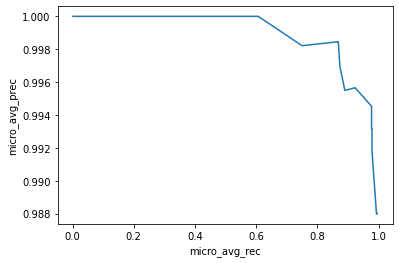

In [38]:
th_rec_prec = ths_prec.merge(ths_rec)
plt.plot(th_rec_prec["micro_avg_rec"], th_rec_prec["micro_avg_prec"])
plt.xlabel("micro_avg_rec")
plt.ylabel("micro_avg_prec")

Unfortunately, lowering threshold introduces false positives.

In [39]:
th_rec_prec[24:28]

,th_offset,micro_avg_prec,micro_avg_rec
24,1,1.000000,0.605369
25,0,1.000000,0.606711
26,-1,0.998214,0.750336
27,-2,0.998221,0.753020


## Quick overview over the linear dependencies

In [40]:
def list2dict(row):
    dic = {}
    #dic["name"] = row["name"] 
    #dic["cd_name"] = row["cd_name"] 
    
    if not row["comparison_vec"]:
        return
    dic["prop_count"] = row["prop_count"]
    for el in row["comparison_vec"]:
        dic[el["id"]] = el["value"]
        

    return dic

comparison_dicts =  cd_table_full.apply(lambda x: list2dict(x), axis=1)#.to_list()
comparison_vecs = pandas.DataFrame(comparison_dicts[~comparison_dicts.isna()].to_list())#.assign(match = cd_table_full["match"].astype

As one may expect, the date of birth contribute strongest to the decision, followed by the name (found in "all_labels"). This rather low contribution of the name results from the bias introduced by the search beforhand, which queried the name.

In [41]:
lm = LinearRegression().fit(comparison_vecs.fillna(0)/100, 
        cd_table_full["match"][~cd_table_full["comparison_vec"].isna()])
pandas.DataFrame(lm.coef_, index=comparison_vecs.columns).T


,prop_count,P569,P19,P968,P735,P734,P856,all_labels,P512
0,-1.947187,0.889649,0.067192,-1.387779e-17,0.001786,-0.004953,0.0,0.247095,-0.022353


# Merge Entities

In [17]:
everypolitician_dicts = read_ftm_json("./data/output/everypolitician.json")
ftm_everypolitician =[model.get_proxy(entity) for entity in everypolitician_dicts] 
#if entity["schema"] == "Person"]



In [21]:
df_evplt = entity2df(ftm_everypolitician)
df_evplt["wikidataId"].duplicated()

0         False
1          True
2          True
3          True
4          True
          ...  
277375    False
277376    False
277377     True
277378     True
277379     True
Name: wikidataId, Length: 277380, dtype: bool

In [28]:
df_evplt["wikidataId"][~df_evplt["wikidataId"].isna()][df_evplt["wikidataId"][~df_evplt["wikidataId"].isna()].duplicated()]

4533       Q327591
4942       Q327591
5743       Q327591
7727       Q969757
8941       Q373047
            ...   
276586    Q3379784
276666    Q2934607
276991    Q1757843
277169      Q10691
277180    Q3396810
Name: wikidataId, Length: 589, dtype: object

In [32]:
a = df_evplt[df_evplt["id"] == "2e685fde839d0217b1ac6455d406e9aef6991da9"]

In [55]:
intersection = clean_person_df[np.in1d(clean_person_df["wikidata"],df_evplt["wikidataId"])]

In [56]:
intersection

,id,birthDate,birthPlace,country,email,firstName,lastName,name,sourceUrl,summary,website,title,wikidata
8,034bf9079555c4722e42de16b6b0c9dc3bef12ca,1981-10-16,"Kulu, Türkei",at,dialogbuero.wien@gruene.at,Aygül Berîvan,Aslan,Aygül Berîvan Aslan,https://www.meineabgeordneten.at/Abgeordnete/A...,[Österreichische Gesellschaft zur Förderung de...,"[https://www.instagram.com/berivan_aslan/, htt...",Mag.a,Q15792244
12,0481dce38b1207403942d8bdfe7c21fea65c422b,1985-03-19,Rum,at,sigi.maurer@gruene.at,Sigrid,Maurer,Sigrid Maurer,https://www.meineabgeordneten.at/Abgeordnete/S...,Abgeordnete zum Nationalrat,"[https://www.facebook.com/sigrid.maurer, https...",NaN,Q1618939
17,05f306ebe8d37ce924b72b1520cff592093907c4,1976-02-27,Salzburg,at,conny.ecker@gmail.com,Cornelia,Ecker,Cornelia Ecker,https://www.meineabgeordneten.at/Abgeordnete/C...,"[Mitglied der Gemeindevertretung, Jugend am We...","[https://www.facebook.com/conny.ecker.spoe, ht...",NaN,Q15616501
24,079f985b4d42a1f0c710b529f5d237007f1ee569,1966-01-04,Friesach,at,kassegger@bloomix.at,Axel,Kassegger,Axel Kassegger,https://www.meineabgeordneten.at/Abgeordnete/A...,"[Holding Graz-Kommunale Dienstleistungen GmbH,...",https://www.facebook.com/profile.php?id=100010...,MMMag. Dr.,Q15784856
27,07ec13b200e35f2ab851c3853b897102d745d90a,1967-08-21,Lang (Steiermark),at,josef.muchitsch@parlament.gv.at,Josef,Muchitsch,Josef Muchitsch,https://www.meineabgeordneten.at/Abgeordnete/J...,"[BUAK Betriebliche Vorsorgekasse GesmbH, Abgeo...","[https://twitter.com/JosefMuchitsch, https://w...",NaN,Q1705321
...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,e91ee97e5e74be32acf69dce1d2b423bb84e772c,1956-10-07,Wien,at,johannes.huebner@fpoe.at,Johannes,Hübner,Johannes Hübner,https://www.meineabgeordneten.at/Abgeordnete/J...,"[PHB Immobilienverwertungsgesellschaft m.b.H.,...",NaN,Dr.,Q1522895
699,e929bcf4f4571033026213714b7733d6d432aa33,1961-10-14,St. Pölten (Niederösterreich),at,wolfgang.gerstl@parlament.gv.at,Wolfgang,Gerstl,Wolfgang Gerstl,https://www.meineabgeordneten.at/Abgeordnete/W...,"[Österreichische Blindenwohlfahrt, Abgeordnete...","[https://www.facebook.com/wgerstl/, https://tw...",Mag.,Q2589687
734,f3ed38b4bc091f39b1596232109b73149f0e4af3,1968-06-19,Waidhofen/Ybbs,at,mail@andreas-hanger.at,Andreas,Hanger,Andreas Hanger,https://www.meineabgeordneten.at/Abgeordnete/A...,"[Wirtschaftspark Ybbstal GmbH, Österreichische...","[https://www.instagram.com/andreas_hanger/, ht...",Mag.,Q15783312
738,f6311c1d51c86d3ec3c8b9438d0092cfcb4cfe96,1956-01-28,Wien,at,ruth.becher@parlament.gv.at,Ruth,Becher,Ruth Becher,https://www.meineabgeordneten.at/Abgeordnete/R...,"[Verein Donaustädter Sport- und Kulturwochen, ...",NaN,Mag.a,Q2177565


In [62]:
import followthemoney.dedupe as dedupe
match = dedupe.Match(ftm.model, {})

In [770]:
response = requests.get(suggest_endpoint.geturl() + "/type" + "?prefix=entity" )

In [771]:
response.content

b'{"result":[{"description":"Entit\\u00e4t mit begrenztem Territorium, die zu administrativen Zwecken bestimmt wurde","id":"Q56061","name":"administrativ-territoriale Entit\\u00e4t"},{"description":"etwas, das existiert","id":"Q35120","name":"Entit\\u00e4t"},{"description":"Wikimedia-Begriffskl\\u00e4rungsseite","id":"Q395312","name":"Entit\\u00e4t"},{"description":"Album von Origin","id":"Q3055100","name":"Entity"},{"description":"2014 debut studio album by Oscar and the Wolf","id":"Q63020308","name":"Entity"},{"description":"Wikimedia-Begriffskl\\u00e4rungsseite","id":"Q8776407","name":"Entity"},{"description":"thriller von 2012","id":"Q16991800","name":"Entity"}]}'

In [736]:
import followthemoney_enrich as enrich

In [742]:
wd_enrich = enrich.get_enricher("opencorporates")

In [748]:
p = enrich.AlephEnricher().convert_entity(ftm_persons)

In [750]:
p == None

True